# Imports

In [1]:
import shutil
import os

from molgroups.support import molstat
from molgroups.infotheory import entropy

print(os.getcwd())

C:\Users\Frank Heinrich\PycharmProjects\molgroups\examples\information_theory\entropy_gridsearch_singlethread\refl1d


# Create Short Example Fit

A functional fit needs to be provided loading simX.dat data files. Currently, the information theory package requires all parameters to be defined using the Parameter() method, and names should not contain spaces. Solvent nSLDs need to be named rho_solv_X to allow the correct background scattering to be calculated.

In [2]:
%%writefile ssblm.py
## === Import section ===
import sys
# append path to your molgroups, or just link molgroups to your same directory
import numpy as np
from molgroups import mol
from molgroups import lipids
from molgroups import components as cmp
from refl1d.names import load4, Parameter, SLD, Slab, Stack, Experiment, FitProblem
from refl1d.flayer import FunctionalProfile

## === Film structure definition section ===

### Bilayer profile definition function

def bilayer(z, sigma, bulknsld, global_rough, rho_substrate, l_submembrane, l_lipid1, l_lipid2, vf_bilayer):
    """ Fairly generic bilayer. This assumes a stack of materials already existing because siox.l is set to zero """
    
    # Set unused parameters
    l_siox = 0.0 # could make a parameter in the future
    rho_siox = 0.0

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6
    rho_substrate *= 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, global_rough=global_rough, rho_substrate=rho_substrate, rho_siox=rho_siox, l_siox=l_siox,
              l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer)
    
    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = blm.fnWriteProfile(z)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # Return nSLD profile in Refl1D units
    return nsld*1e6

### Define bilayer parameters
vf_bilayer = Parameter(name='volume_fraction_bilayer', value=0.9).range(0.0, 1.0)
l_lipid1 = Parameter(name='inner_acyl_chain_thickness', value=10.0).range(8, 16)
l_lipid2 = Parameter(name='outer_acyl_chain_thickness', value=10.0).range(8, 16)
sigma = Parameter(name='bilayer_roughness', value=5).range(2, 9)
global_rough = Parameter(name ='tiox_roughness', value=5).range(2, 9)
l_tiox = Parameter(name='total_tiox_thickness', value=120).range(50, 150)
l_submembrane = Parameter(name='submembrane_thickness', value=10).range(0, 50)

### Define bilayer object
blm = mol.ssBLM(lipids=[lipids.DOPC], lipid_nf=[1.0])

### Define molgroups space.
dimension=300       # Number of steps
stepsize=0.5        # Length of steps

## === Stack ===
##
## First, we create a 'material' for each bulk layer, which has an real and imaginary
## scattering length density, stored in a Refl1d object called 'SLD'
d2o = SLD(name='d2o', rho=6.3000, irho=0.0000)
h2o = SLD(name='h2o', rho=-0.56, irho=0.0000)
tiox = SLD(name='tiox', rho=2.1630, irho=0.0000)
siox = SLD(name='siox', rho=4.1000, irho=0.0000)
silicon = SLD(name='silicon', rho=2.0690, irho=0.0000)

## Then bulk layers are created, each with its own 'material'.  If you want to force
## two layers to always match SLD you can use the same material in multiple layers.
## The roughnesses of each layer are set to zero to begin with:

layer_d2o = Slab(material=d2o, thickness=0.0000, interface=5.0000)
layer_h2o = Slab(material=h2o, thickness=0.0000, interface=5.0000)
layer_tiox = Slab(material=tiox, thickness=l_tiox - (blm.substrate.z + 0.5 * blm.substrate.l), interface=0.0)
layer_siox = Slab(material=siox, thickness=7.5804, interface=10.000)
layer_silicon = Slab(material=silicon, thickness=0.0000, interface=0.0000)

## Set sample parameter ranges and constraints between layer properties
# layer roughness parameters
###################################################################
## the 'interface' associated with layer0 is the boundary between #
## layer0 and layer1, and similarly for layer(N) and layer(N+1)   #
###################################################################
layer_siox.interface = siox_interface = Parameter(name='siox_interface', value=5.0).range(2.0000, 9.000)

# Si and SiOx roughnesses are the same
layer_silicon.interface = layer_siox.interface

# nSLD parameters
d2o.rho = rho_d2o = Parameter(name='rho_solv_0', value=6.34).range(5.3000, 6.5000)
h2o.rho = rho_h2o = Parameter(name='rho_solv_1', value=-0.56).range(-0.6, 0.6)
tiox.rho = rho_tiox = Parameter(name='rho_tiox', value=2).range(1.1630, 3.1630)
siox.rho = rho_siox = Parameter(name='rho_siox', value=3.5).range(3.1000, 5.1000)

# layer thickness parameters
layer_tiox.thickness = tiox_thickness = Parameter(name='tiox_thickness', value=100.).range(66.379, 266.38)
layer_siox.thickness = siox_thickness = Parameter(name='siox_thickness', value=30.).range(5, 40)

## Use the bilayer definition function to generate the bilayer SLD profile, passing in the relevant parameters.
## Note that substrate and bulk SLDs are linked to their respective materials.
mollayer = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma,
                                bulknsld=d2o.rho, global_rough=global_rough, rho_substrate=tiox.rho,
                                l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                                vf_bilayer=vf_bilayer)
mollayerh = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma,
                                bulknsld=h2o.rho, global_rough=global_rough, rho_substrate=tiox.rho,
                                l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                                vf_bilayer=vf_bilayer)

## Stack the layers into individual samples, using common layer objects for layers that are unchanged between samples
## As a convention, always build the sample from the substrate up. If the neutron beam is incident from the substrate side,
## set back_reflectivity = True in the probe definition later.

sample = layer_silicon | layer_siox | layer_tiox | mollayer | layer_d2o
sampleh = layer_silicon | layer_siox | layer_tiox | mollayerh | layer_h2o

## === Data files ===
probe = load4('sim0.dat', back_reflectivity=True)
probeh = load4('sim1.dat', back_reflectivity=True)

# Set instrumental (probe) parameters
probe.background = background_0 = Parameter(name='background_0', value=0.).range(-1e-7, 1e-5)
probeh.background = background_1 = Parameter(name='background_1', value=0.).range(-1e-7, 1e-5)
probe.intensity = intensity = Parameter(name='intensity', value=1.0).range(0.9, 1.05)
probeh.intensity = probe.intensity
probe.theta_offset = theta_offset = Parameter(name='theta_offset', value=0.).range(-0.015, 0.005)
probeh.theta_offset = probe.theta_offset
probe.sample_broadening = sample_broadening = Parameter(name='sample_broadening', value=0).range(-0.005, 0.02)
probeh.sample_broadening = probe.sample_broadening

# Define critical edge oversampling for samples that require it
# probe.critical_edge(substrate=silicon, surface=d2o)

## === Problem definition ===
## a model object consists of a sample and a probe.

## step = True corresponds to a calculation of the reflectivity from an actual profile
## with microslabbed interfaces.  When step = False, the Nevot-Croce
## approximation is used to account for roughness.  This approximation speeds up
## the calculation tremendously, and is reasonably accuarate as long as the
## roughness is much less than the layer thickness
step = False

model = Experiment(sample=sample, probe=probe, dz=stepsize, step_interfaces = step)
modelh = Experiment(sample=sampleh, probe=probeh, dz=stepsize, step_interfaces = step)

problem = FitProblem([model, modelh])

## === Export objects for post analysis ===
problem.name = "DOPC bilayer on TiOx substrate"
problem.bilayers = [blm]
problem.dimension = dimension
problem.stepsize = stepsize


Overwriting ssblm.py


No file: C:\Users\Frank Heinrich\PycharmProjects\molgroups\examples\information_theory\entropy_gridsearch_singlethread\refl1d\T\ssblm.py
No state to reload.
# steps: 3, # draws: 540
step 1 cost 85.824(84)
                            background_0 ..|....... 2.5354e-06 in (-1e-07,1e-05)
                               intensity .|........   0.920097 in (0.9,1.05)
                       sample_broadening .|........ -0.00185351 in (-0.005,0.02)
                            theta_offset ......|... -0.00110459 in (-0.015,0.005)
                          siox_interface ....|.....    5.10718 in (2,9)
                                rho_siox ..|.......     3.6266 in (3.1,5.1)
                          siox_thickness ......|...    27.8597 in (5,40)
                                rho_tiox .....|....    2.28614 in (1.163,3.163)
                          tiox_thickness ..|.......    107.886 in (66.379,266.38)
                              rho_solv_0 ........|.    6.35414 in (5.3,6.5)
               

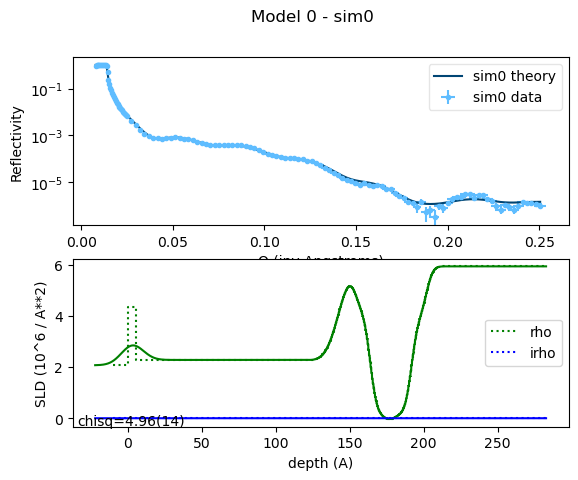

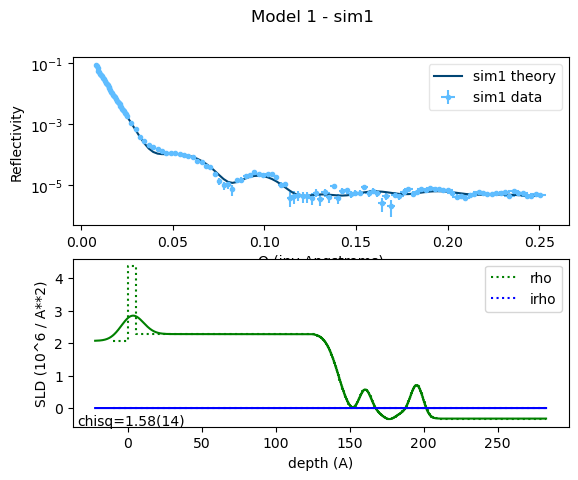

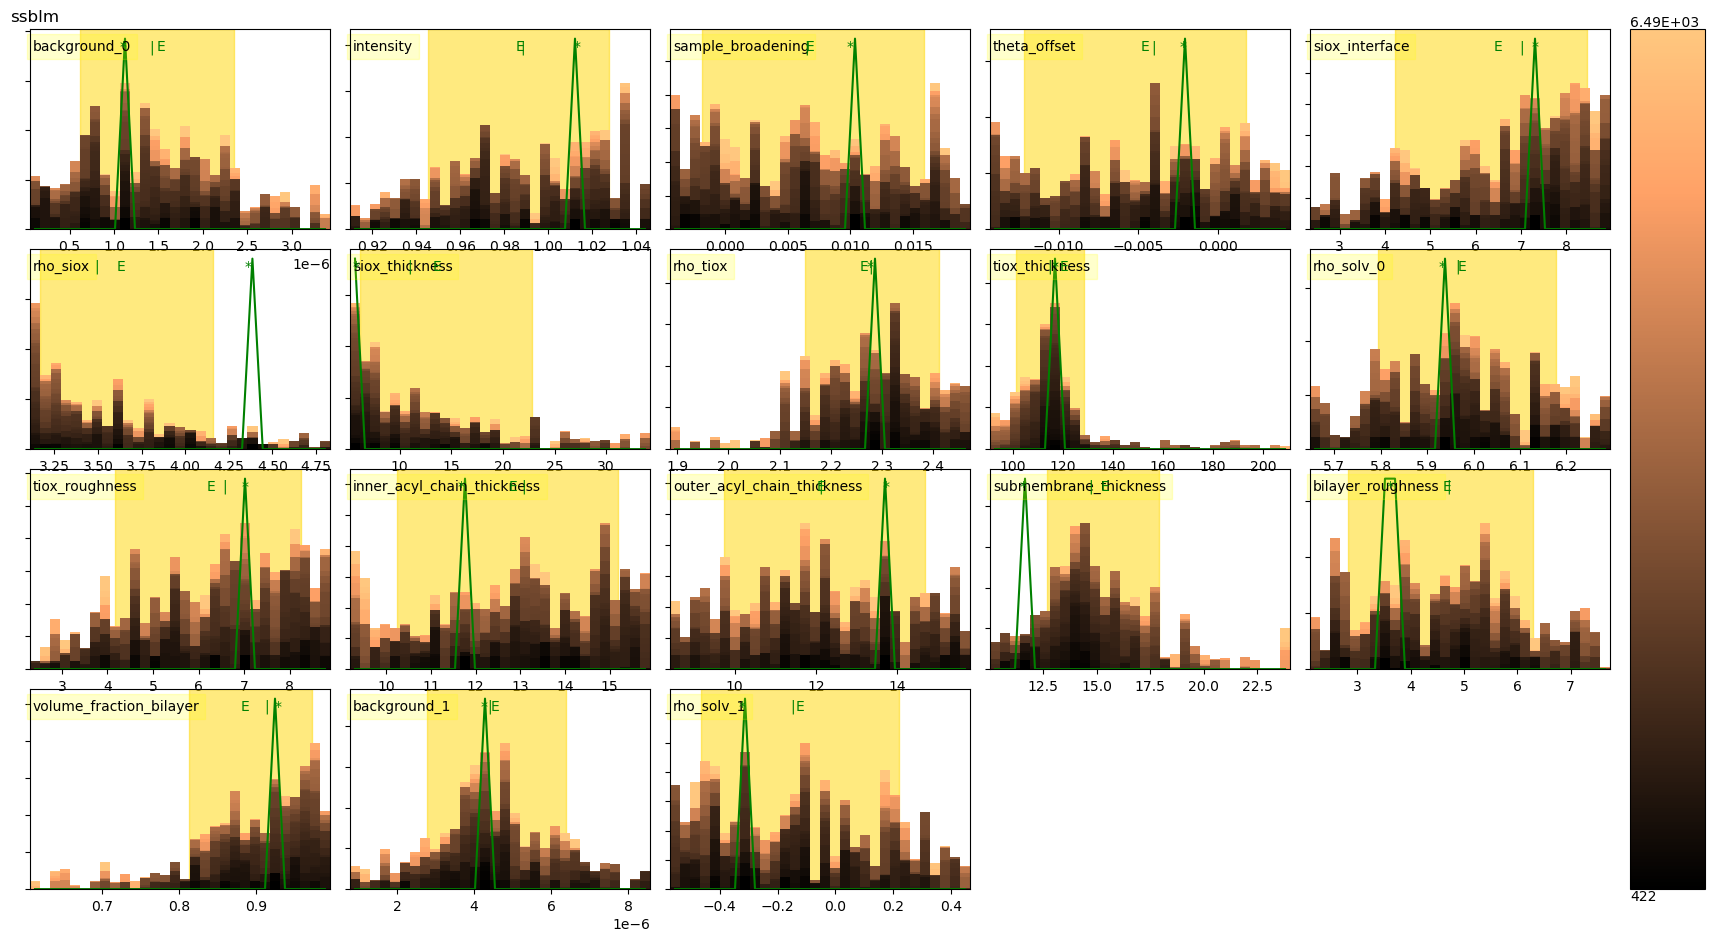

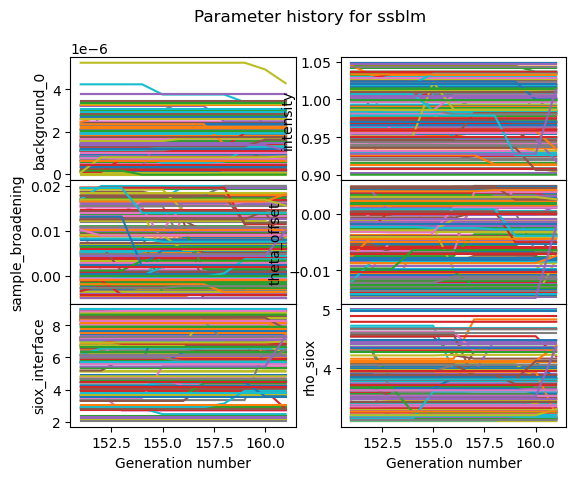

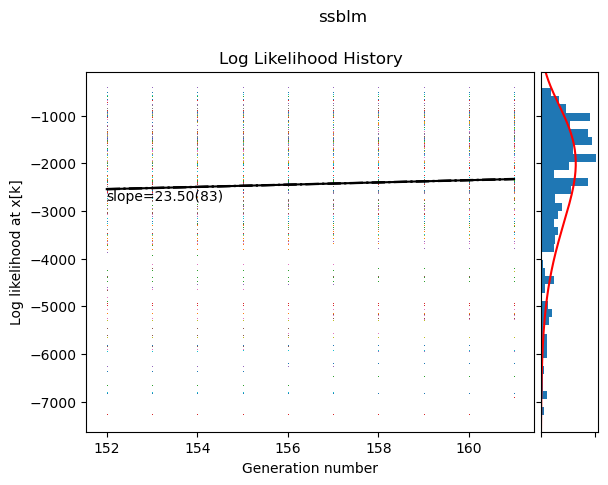

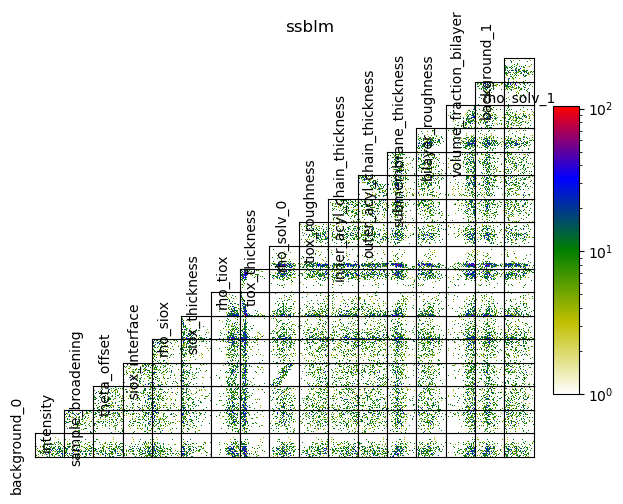

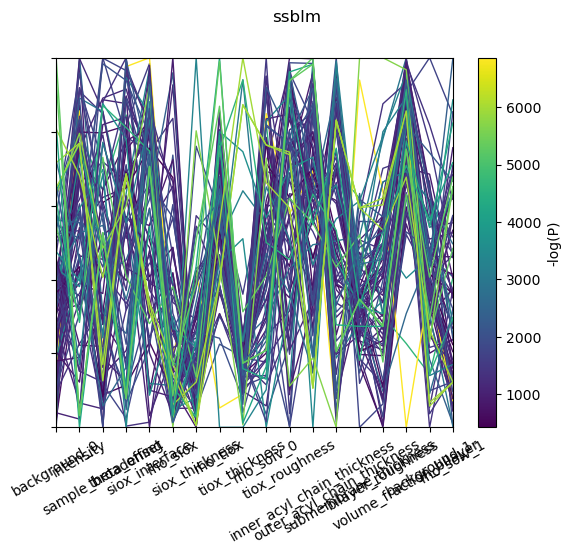

In [3]:
shutil.copyfile('ch060.refl', 'sim1.dat')
shutil.copyfile('ch061.refl', 'sim0.dat')

setupdir = os.getcwd()
store = "T"
runfile = "ssblm"
fitsource = "refl1d"
if not os.path.isdir(store):
    os.mkdir(store)
burn = 8000
steps = 500

fit_object = molstat.CMolStat(fitsource=fitsource, spath=setupdir, mcmcpath=store, runfile=runfile, state=None, problem=None)
fit_object.Interactor.fnRunMCMC(burn, steps, batch=False)

# Defining Optimization Parameters in entropypar.dat

* Entropypar.dat contains a list of all fit parameters with a designation, whether they are marginal (d) or nuisance (i) parameters. This is followed by the parameter name, the initial parameter value, and the fit boundaries. 
* If three more numbers are given, this designates that an information content search over this parameter is performed (start, stop, step). 
* A preceding f (fi or fd) at the beginning of the line indicates that the fit boundaries for such a search parameter are fixed (for example for volume fractions between 0 and 1), otherwise the fit boundary moves according to the varied parameter and the initally given fit boundaries.
* Any theta offset currently needs to have an initial value of zero. Otherwise refl1d will shift the q-values during data simulation with unexpected outcomes.

In [4]:
%%writefile entropypar.dat
i background_0 1.03489e-06 -1e-07 1e-05
i intensity 1.0 0.9 1.05
i sample_broadening 0 -0.005 0.02
i theta_offset 0.0 -0.015 0.005
i siox_interface 6.85069 2 9
i rho_siox 3.39556 3.1 5.1
i siox_thickness 14.9832 5 40
i rho_tiox 2.32129 1.163 3.163 -1 10 1
i tiox_thickness 110.913 66.379 266.38
i tiox_roughness 6.8149 2 9
d inner_acyl_chain_thickness 11.1605 8 16
d outer_acyl_chain_thickness 13.6487 8 16
d submembrane_thickness 13.9116 0 50
d bilayer_roughness 4.84472 2 9
d volume_fraction_bilayer 0.906858 0 1
i rho_solv_0 6.21572 5.3 6.5
i background_1 3.95582e-06 -1e-07 1e-05
i rho_solv_1 -0.550133 -0.6 0.6
n prefactor 2.58496

Overwriting entropypar.dat


# Variables

In [5]:
# general fit setup
setupdir = os.getcwd()
runfile = "ssblm"
store = 'T'
fitsource = "refl1d"

# particular entropy setup
burn = 8000
steps = 500
convergence = 2.0
miniter = 1
mode = 'water'
bClusterMode = False
bFetchMode = False
time = 2
bcalcsymmetric = True
upper_info_plotlevel = None
plotlimits_filename = ""
calcsingle = False

# setup batchscript for SLURM (if used)
script = []
script.append('#!/bin/bash\n')
script.append('#SBATCH --job-name=entro {mcmc_iteration}\n')
script.append('#SBATCH -A mc4s9np\n')
script.append('#SBATCH -p RM\n')
script.append('#SBATCH -t 0' + str(time) + ':00:00\n')
script.append('#SBATCH -N 4\n')
script.append('#SBATCH --ntasks-per-node 28\n')
script.append('\n')
script.append('set +x\n')
script.append('cd $SLURM_SUBMIT_DIR\n')
# script.append('cd '+dirname+'\n')
script.append('\n')
script.append('module load python/2.7.11_gcc\n')
script.append('export PYTHONPATH=/home/hoogerhe/bin/lib/python2.7/site-packages:/home/hoogerhe/src/bumps\n')
script.append('\n')
script.append('mpirun -np 112 python /home/hoogerhe/src/refl1d/bin/refl1d_cli.py {mcmc_dirname}/run.py --fit=dream --mpi --init=lhs --batch --pop=28 --time=' 
              + str(float(time) - 0.1) + ' --thin=20 --store={mcmc_dirname}/save --burn=' + str(burn) 
              + ' --steps=' + str(steps) + '\n')


# Fit Setup

In [6]:
entr = entropy.Entropy(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    mcmcburn=burn, 
    mcmcsteps=steps, 
    convergence=convergence, 
    miniter=miniter, 
    mode=mode,                      
    bClusterMode=bClusterMode, 
    bFetchMode=bFetchMode, 
    calc_symmetric=bcalcsymmetric,
    upper_info_plotlevel=upper_info_plotlevel, 
    plotlimits_filename=plotlimits_filename,
    slurmscript=script
)

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox -1.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 7.63943e-07 in [-1e-07,1e-05]
  .intensity = 0.994623 in [0.9,1.05]
  .sample_broadening = 0.00661774 in [-0.005,0.02]
  .theta_offset = -0.00424935 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 6.21596 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 6.21596 in [2,

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 0.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 7.64239e-07 in [-1e-07,1e-05]
  .intensity = 1.00656 in [0.9,1.05]
  .sample_broadening = 0.00852385 in [-0.005,0.02]
  .theta_offset = -0.00446629 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 2.29181 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 2.29181 in [2,9]

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 1.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 1.55691e-06 in [-1e-07,1e-05]
  .intensity = 0.976387 in [0.9,1.05]
  .sample_broadening = -0.00101381 in [-0.005,0.02]
  .theta_offset = 0.00113071 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 8.2592 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 8.2592 in [2,9]


C:\Users\Frank Heinrich\anaconda3\lib\site-packages\bumps\dream\varplot.py:289: RuntimeWarning: divide by zero encountered in double_scalars
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\bumps\dream\varplot.py:289: RuntimeWarning: invalid value encountered in multiply
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Hein

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 2.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 1.39668e-06 in [-1e-07,1e-05]
  .intensity = 1.02737 in [0.9,1.05]
  .sample_broadening = 0.0169596 in [-0.005,0.02]
  .theta_offset = -0.00807166 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 3.87843 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 3.87843 in [2,9]


C:\Users\Frank Heinrich\anaconda3\lib\site-packages\bumps\dream\varplot.py:289: RuntimeWarning: divide by zero encountered in double_scalars
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\bumps\dream\varplot.py:289: RuntimeWarning: invalid value encountered in multiply
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\bumps\dream\views.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment vari

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 3.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 1.01764e-06 in [-1e-07,1e-05]
  .intensity = 1.01669 in [0.9,1.05]
  .sample_broadening = 0.00640714 in [-0.005,0.02]
  .theta_offset = -0.00126737 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 3.06202 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 3.06202 in [2,9]

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 4.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 1.17898e-06 in [-1e-07,1e-05]
  .intensity = 0.993996 in [0.9,1.05]
  .sample_broadening = 0.00488647 in [-0.005,0.02]
  .theta_offset = -0.00365169 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 7.04271 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 7.04271 in [2,9

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 5.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 2.94333e-07 in [-1e-07,1e-05]
  .intensity = 1.01487 in [0.9,1.05]
  .sample_broadening = 0.00241559 in [-0.005,0.02]
  .theta_offset = -0.0105884 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 6.03404 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 6.03404 in [2,9]


C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 6.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 1.58453e-06 in [-1e-07,1e-05]
  .intensity = 0.996823 in [0.9,1.05]
  .sample_broadening = -0.00473735 in [-0.005,0.02]
  .theta_offset = -0.0131662 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 5.86425 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 5.86425 in [2,9

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 7.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 1.43342e-06 in [-1e-07,1e-05]
  .intensity = 1.01947 in [0.9,1.05]
  .sample_broadening = 0.00412095 in [-0.005,0.02]
  .theta_offset = -0.01191 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 8.20145 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 8.20145 in [2,9]
  

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\bumps\dream\varplot.py:289: RuntimeWarning: divide by zero encountered in double_scalars
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\bumps\dream\varplot.py:289: RuntimeWarning: invalid value encountered in multiply
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Hein

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 8.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 6.04302e-07 in [-1e-07,1e-05]
  .intensity = 0.96761 in [0.9,1.05]
  .sample_broadening = 0.00410455 in [-0.005,0.02]
  .theta_offset = -0.0120493 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 8.23778 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 8.23778 in [2,9]


C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 9.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 6.95178e-07 in [-1e-07,1e-05]
  .intensity = 1.01084 in [0.9,1.05]
  .sample_broadening = -0.00389721 in [-0.005,0.02]
  .theta_offset = -0.0060928 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 5.35227 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 5.35227 in [2,9]

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

No problem to reload.
background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 10.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 1.27622e-06 in [-1e-07,1e-05]
  .intensity = 0.966112 in [0.9,1.05]
  .sample_broadening = -0.00105842 in [-0.005,0.02]
  .theta_offset = -0.00626475 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 5.96725 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 5.96725 in [2

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\bumps\dream\varplot.py:289: RuntimeWarning: divide by zero encountered in double_scalars
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\bumps\dream\varplot.py:289: RuntimeWarning: invalid value encountered in multiply
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Hein

background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox -1.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 1.15209e-06 in [-1e-07,1e-05]
  .intensity = 0.998342 in [0.9,1.05]
  .sample_broadening = 0.00485189 in [-0.005,0.02]
  .theta_offset = -0.00121276 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 8.41585 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 8.41585 in [2,9]
      .material
   

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 0.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = -2.49955e-08 in [-1e-07,1e-05]
  .intensity = 1.01312 in [0.9,1.05]
  .sample_broadening = 0.0178366 in [-0.005,0.02]
  .theta_offset = 0.00260873 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 6.74826 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 6.74826 in [2,9]
      .material
      

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\bumps\dream\varplot.py:289: RuntimeWarning: divide by zero encountered in double_scalars
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\bumps\dream\varplot.py:289: RuntimeWarning: invalid value encountered in multiply
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Hein

background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 1.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 1.13996e-06 in [-1e-07,1e-05]
  .intensity = 1.01651 in [0.9,1.05]
  .sample_broadening = 0.00504872 in [-0.005,0.02]
  .theta_offset = -0.000725671 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 7.64787 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 7.64787 in [2,9]
      .material
    

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 2.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = -9.60157e-10 in [-1e-07,1e-05]
  .intensity = 1.01405 in [0.9,1.05]
  .sample_broadening = 0.00659647 in [-0.005,0.02]
  .theta_offset = 0.00313978 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 8.29183 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 8.29183 in [2,9]
      .material
     

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 3.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 2.58925e-07 in [-1e-07,1e-05]
  .intensity = 1.04497 in [0.9,1.05]
  .sample_broadening = -0.00350816 in [-0.005,0.02]
  .theta_offset = -0.0114069 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 8.62742 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 8.62742 in [2,9]
      .material
     

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 4.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 4.14636e-07 in [-1e-07,1e-05]
  .intensity = 0.994615 in [0.9,1.05]
  .sample_broadening = 0.00610518 in [-0.005,0.02]
  .theta_offset = -0.00512925 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 2.94003 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 2.94003 in [2,9]
      .material
    

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 5.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 1.72476e-06 in [-1e-07,1e-05]
  .intensity = 0.997976 in [0.9,1.05]
  .sample_broadening = 0.000403268 in [-0.005,0.02]
  .theta_offset = -0.014838 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 8.21953 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 8.21953 in [2,9]
      .material
     

C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\infotheory\entropy.py:359: RuntimeWarning: divide by zero encountered in log
  s_est = log(n_est) - mean(eval_logp)
C:\Users\Frank Heinrich\anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Frank Heinrich\PycharmProjects\molgroups\molgroups\info

background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox 6.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# steps: 3, # draws: 540


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Frank Heinrich\\PycharmProjects\\molgroups\\examples\\information_theory\\entropy_gridsearch_singlethread\\refl1d\\iteration_7\\save\\ssblm-slabs.dat'

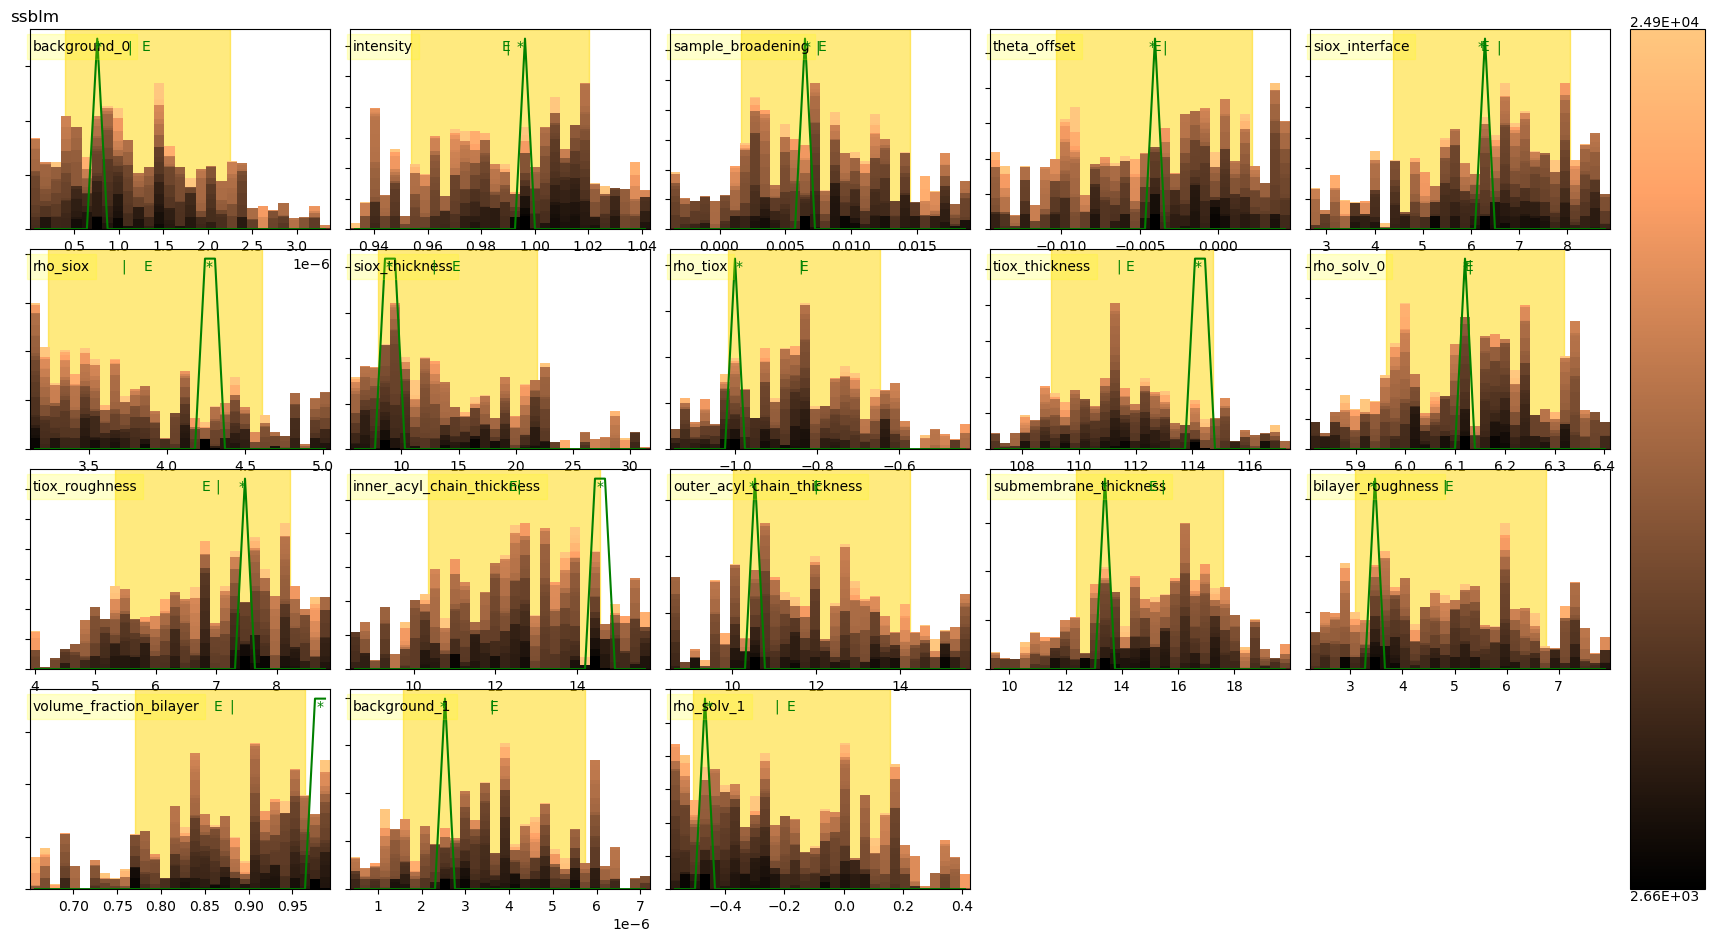

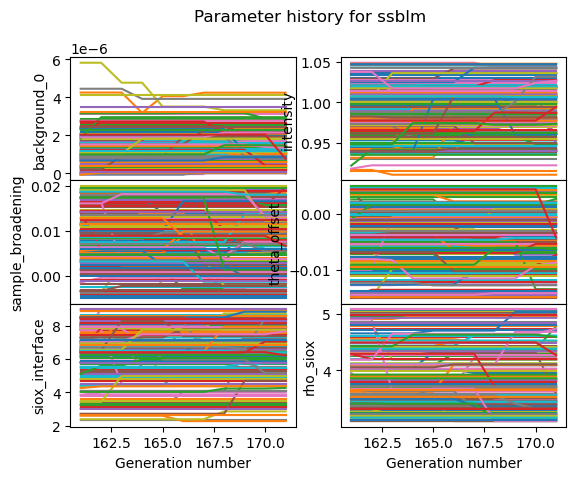

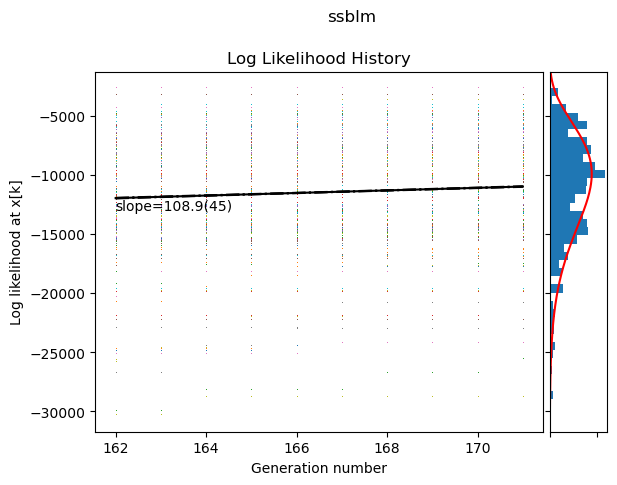

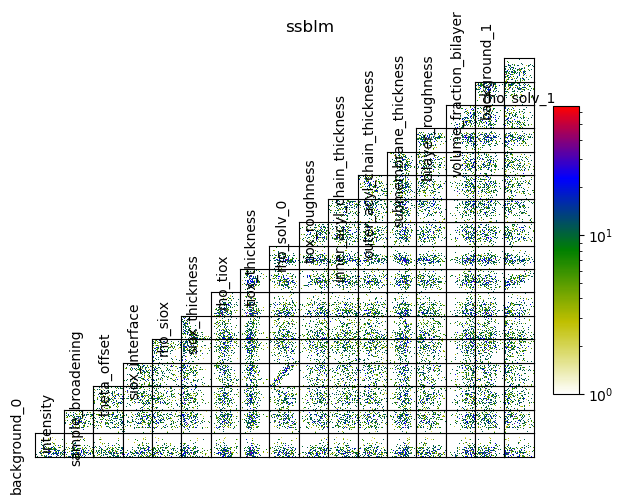

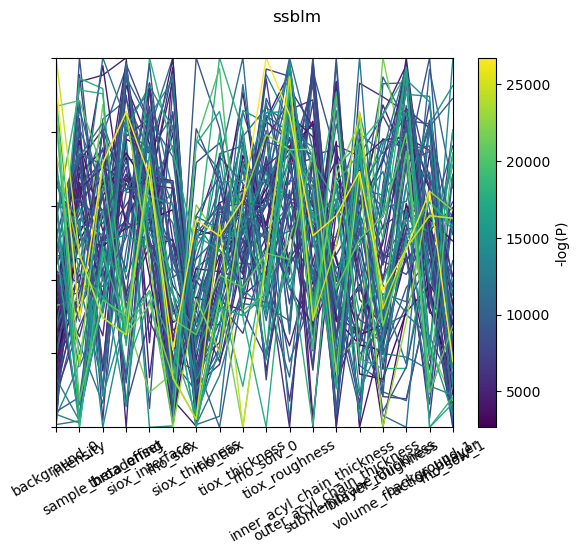

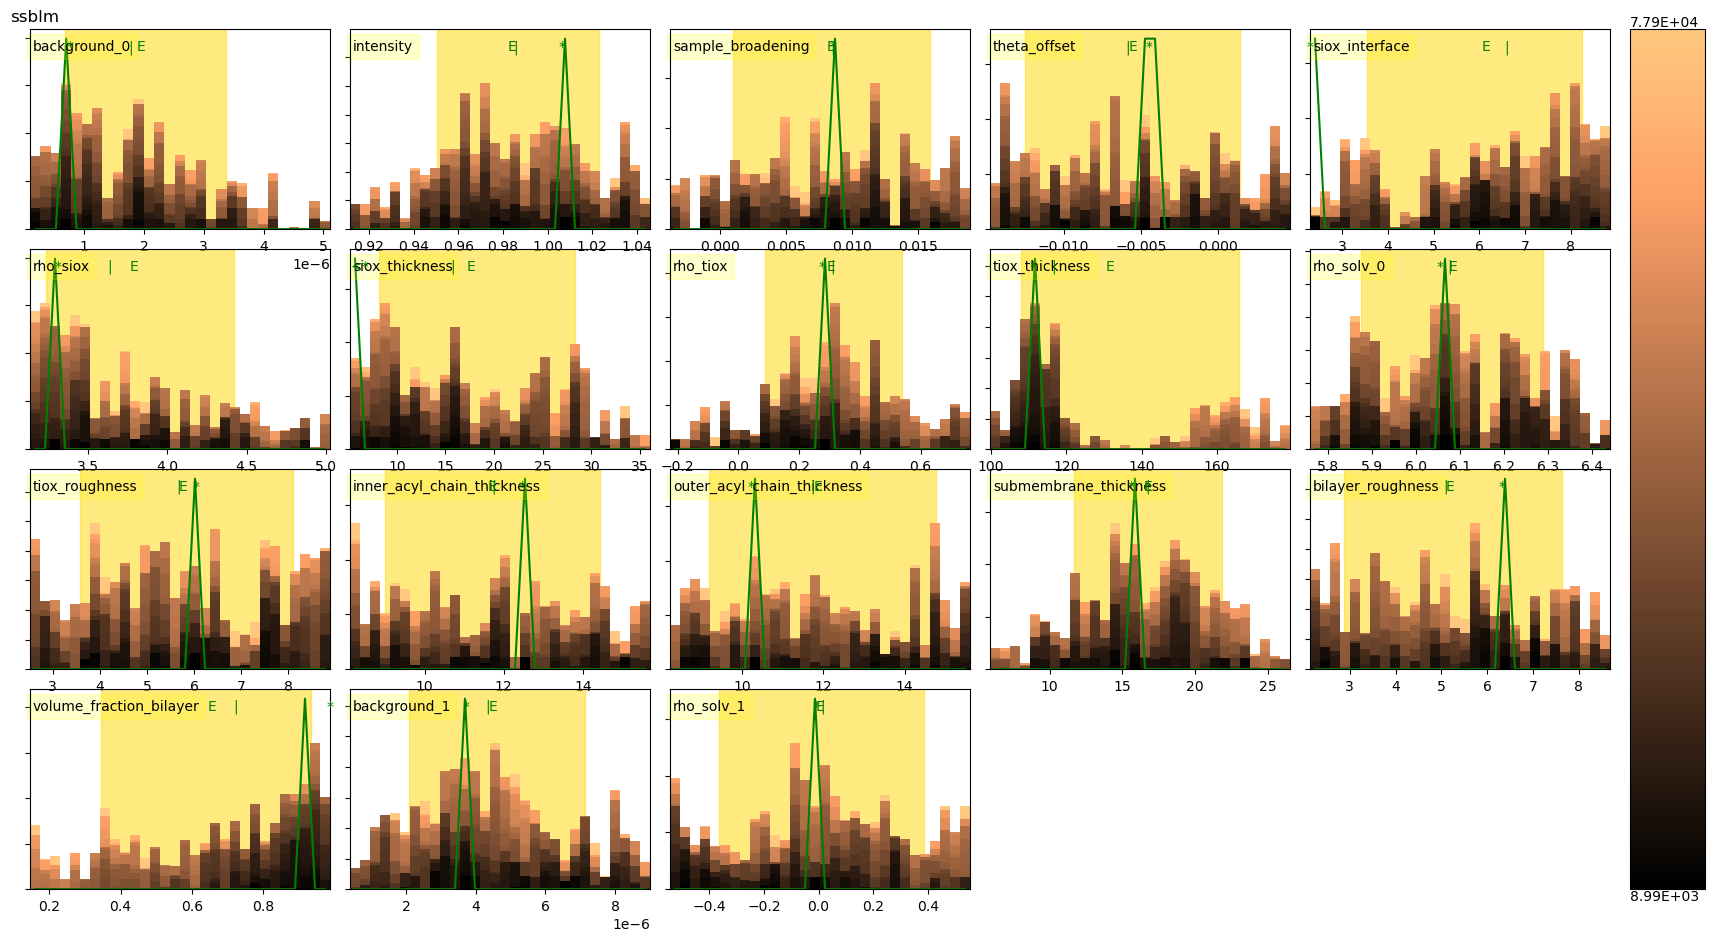

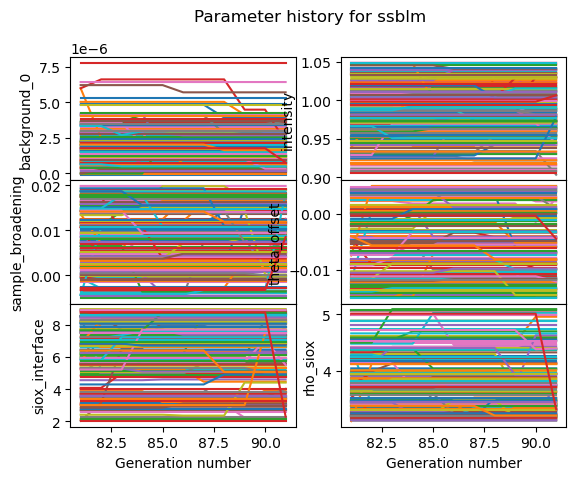

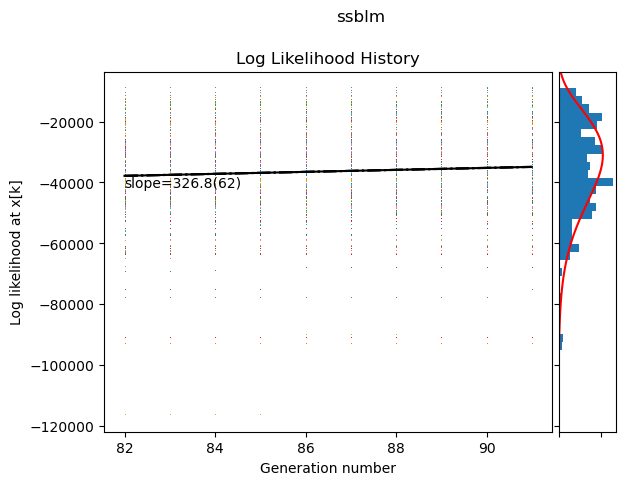

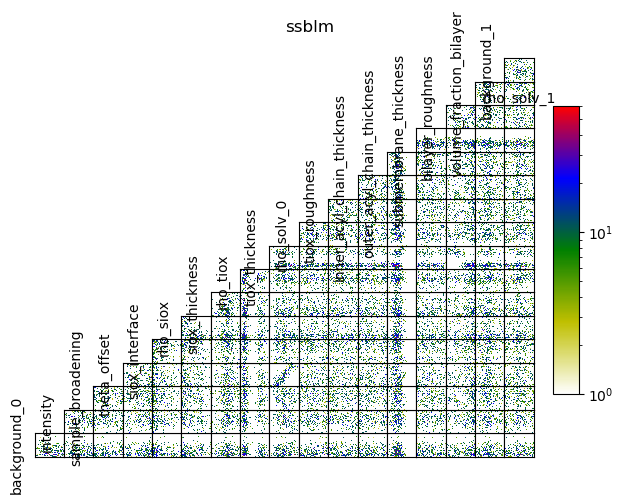

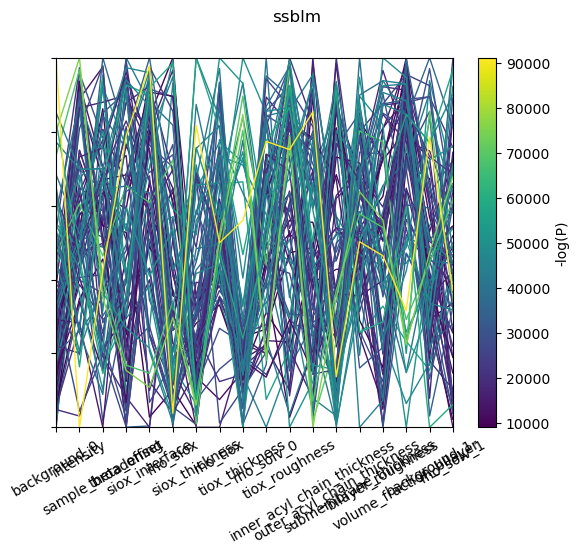

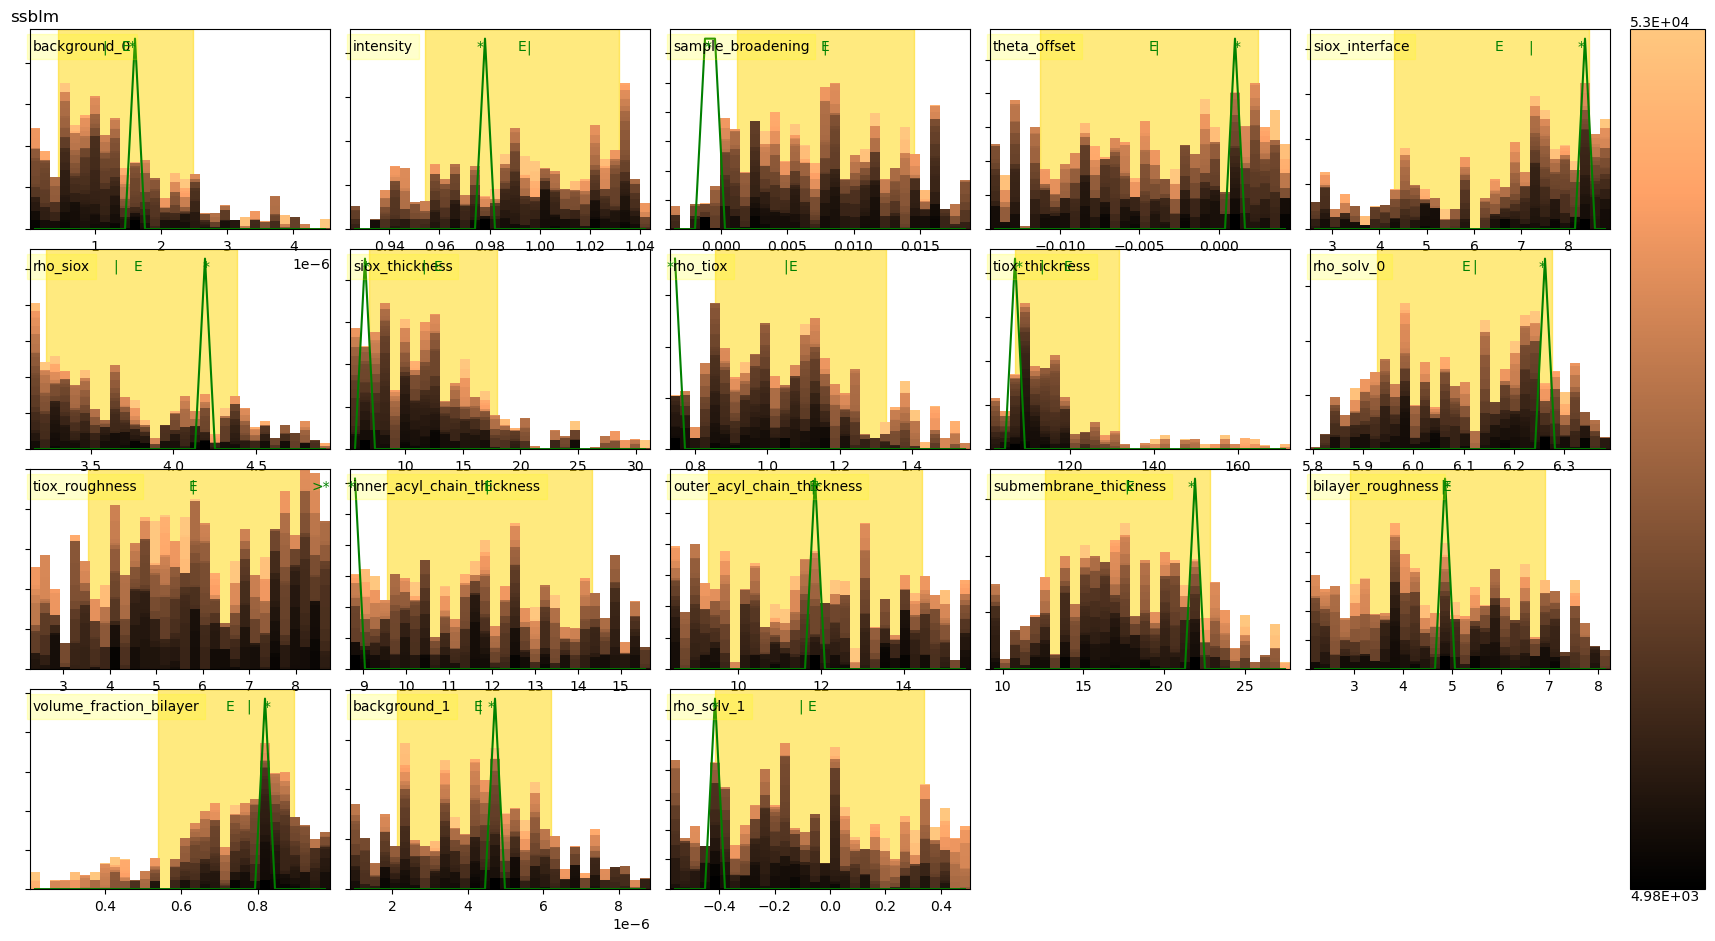

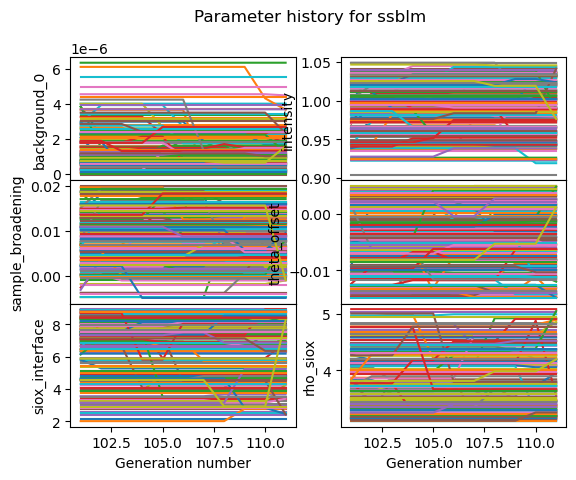

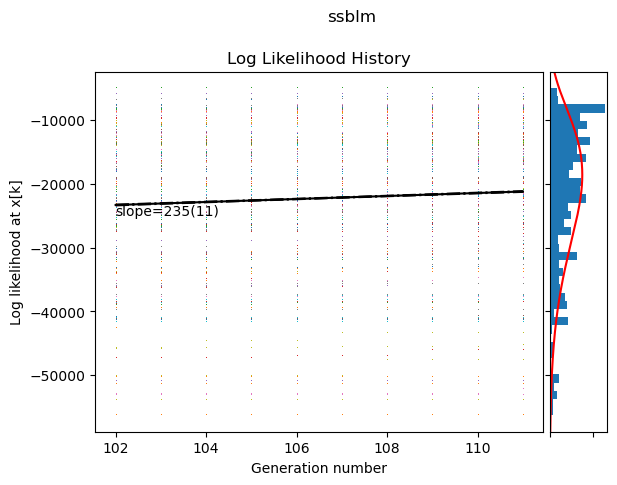

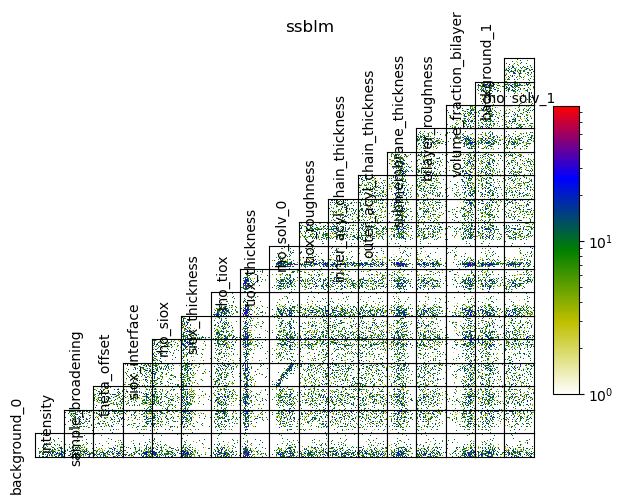

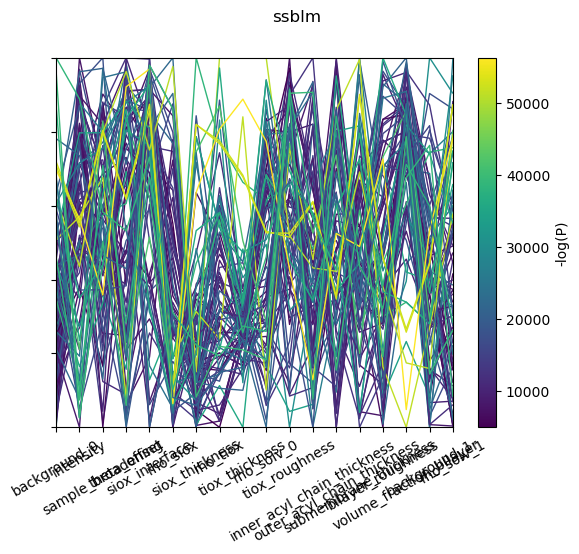

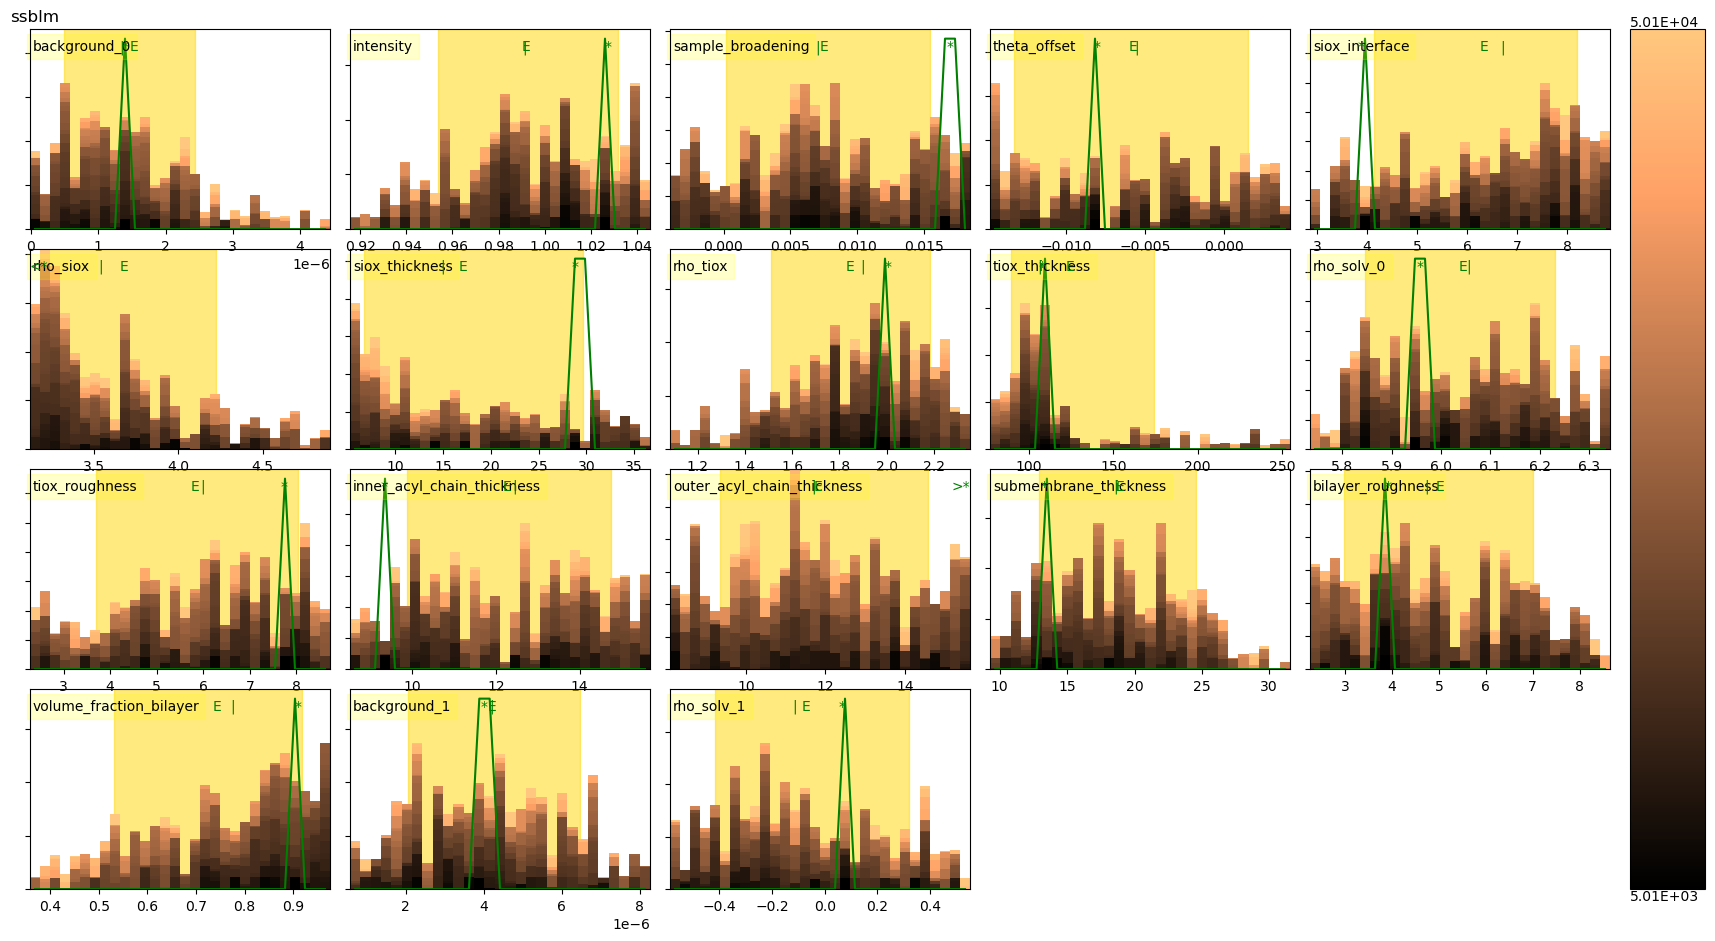

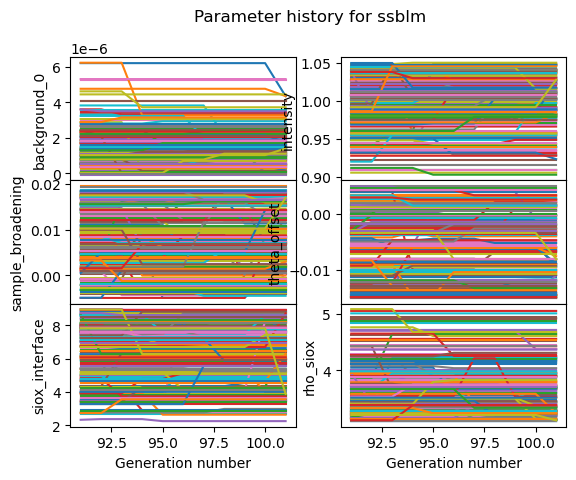

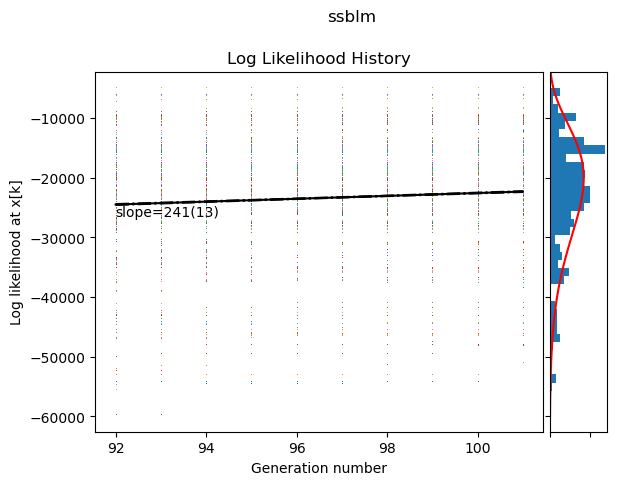

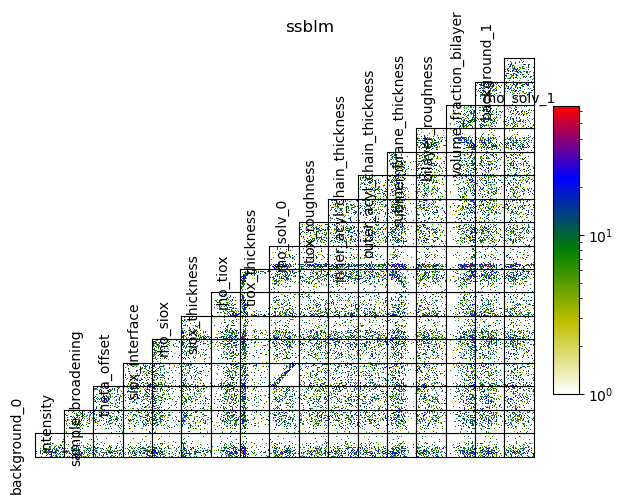

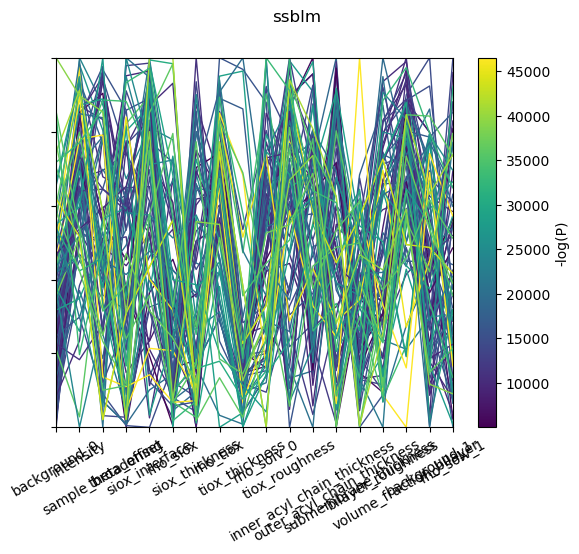

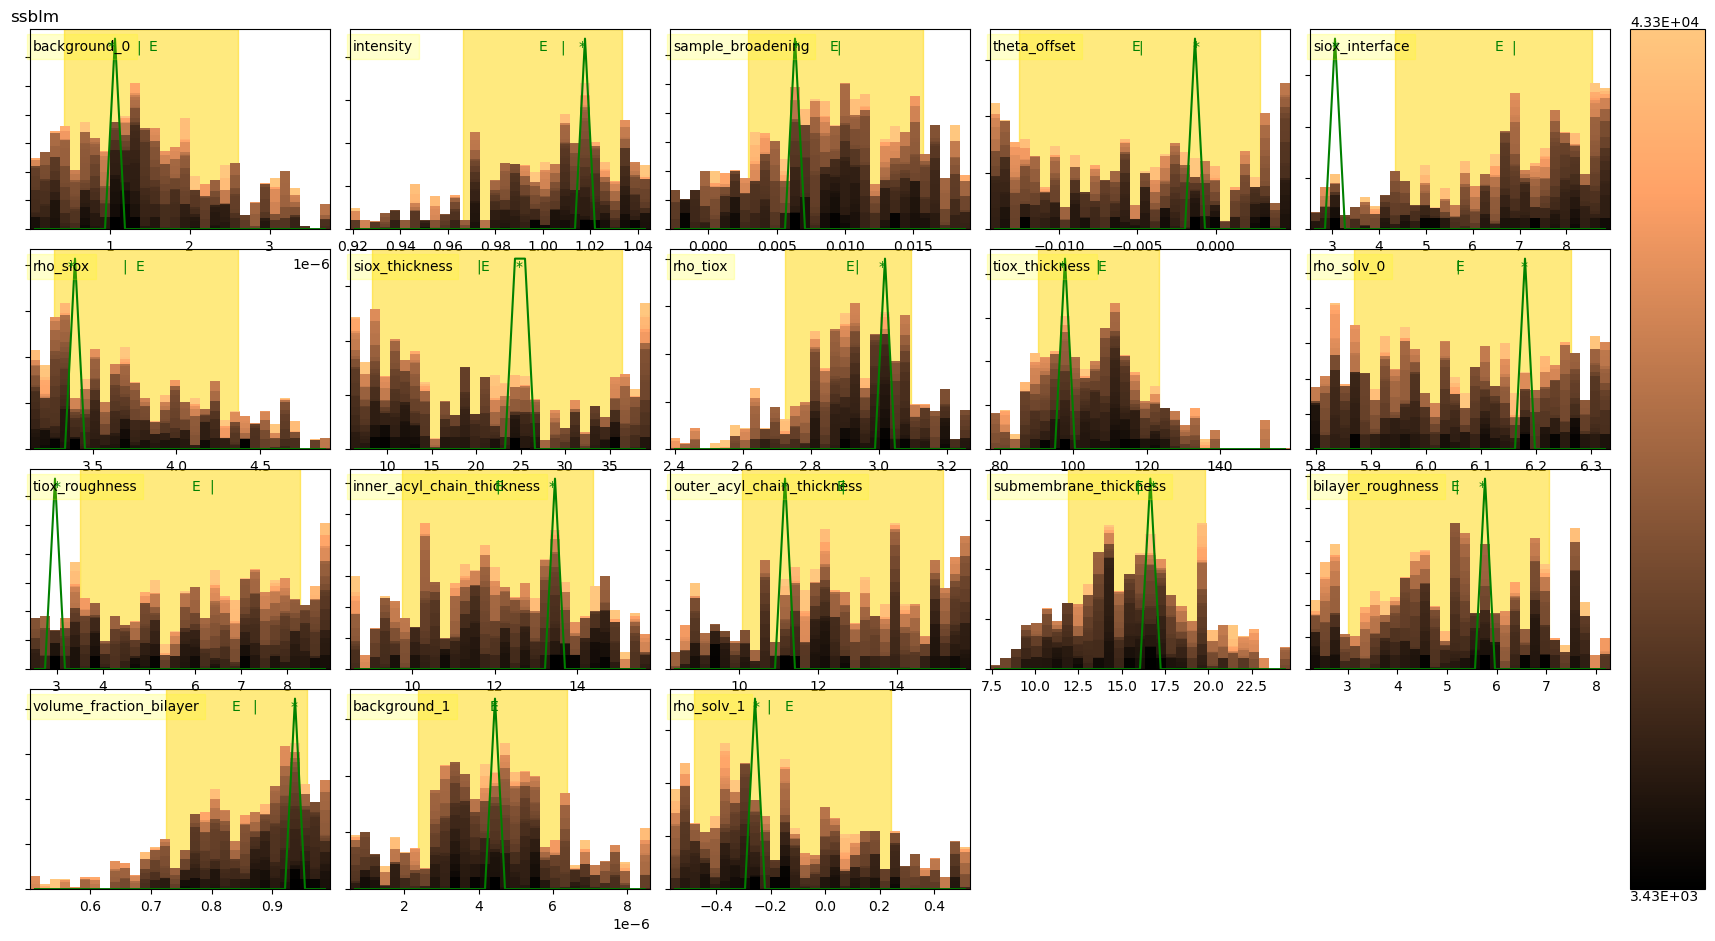

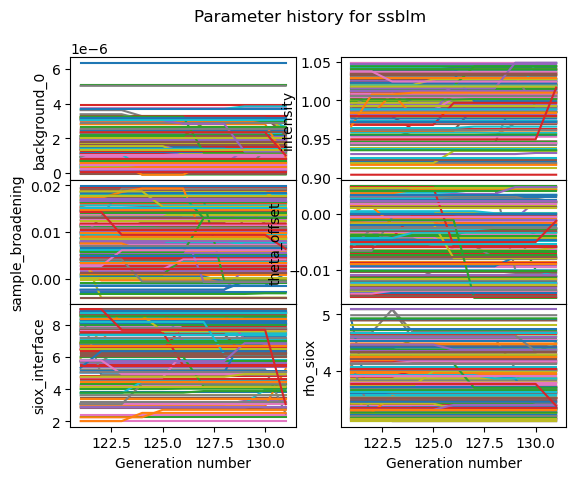

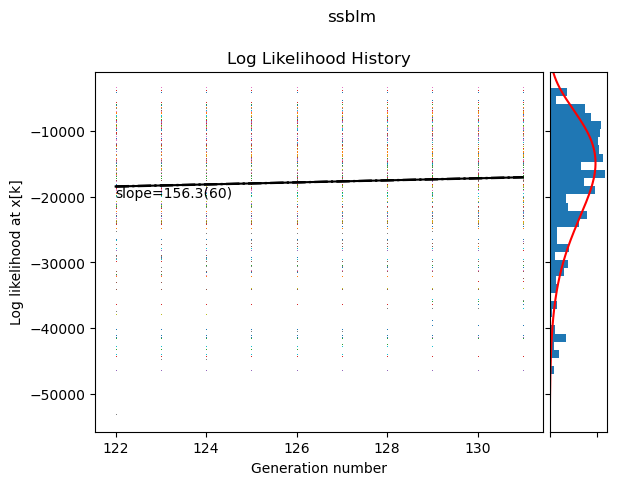

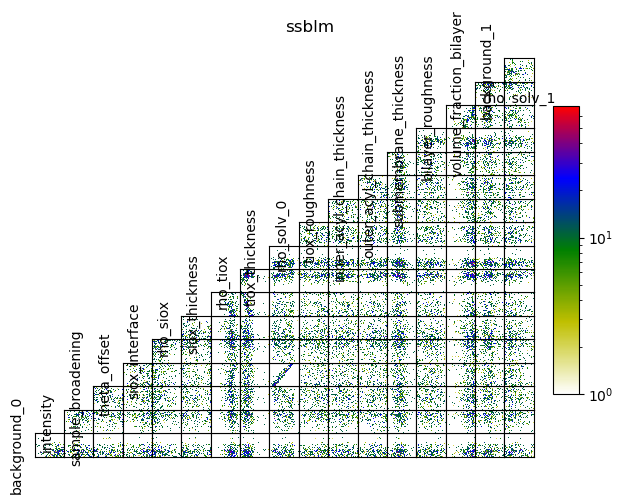

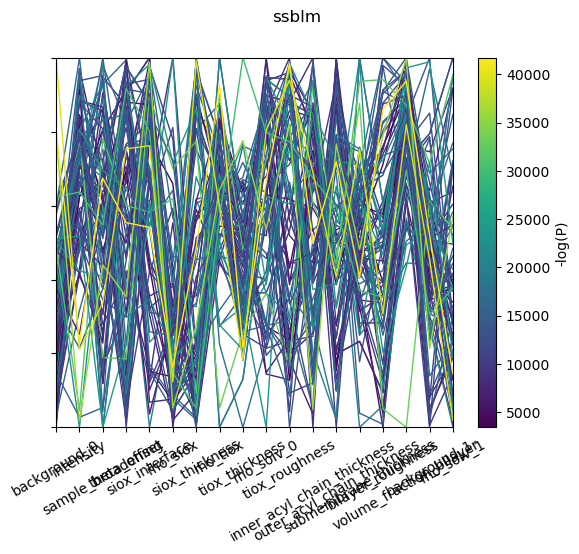

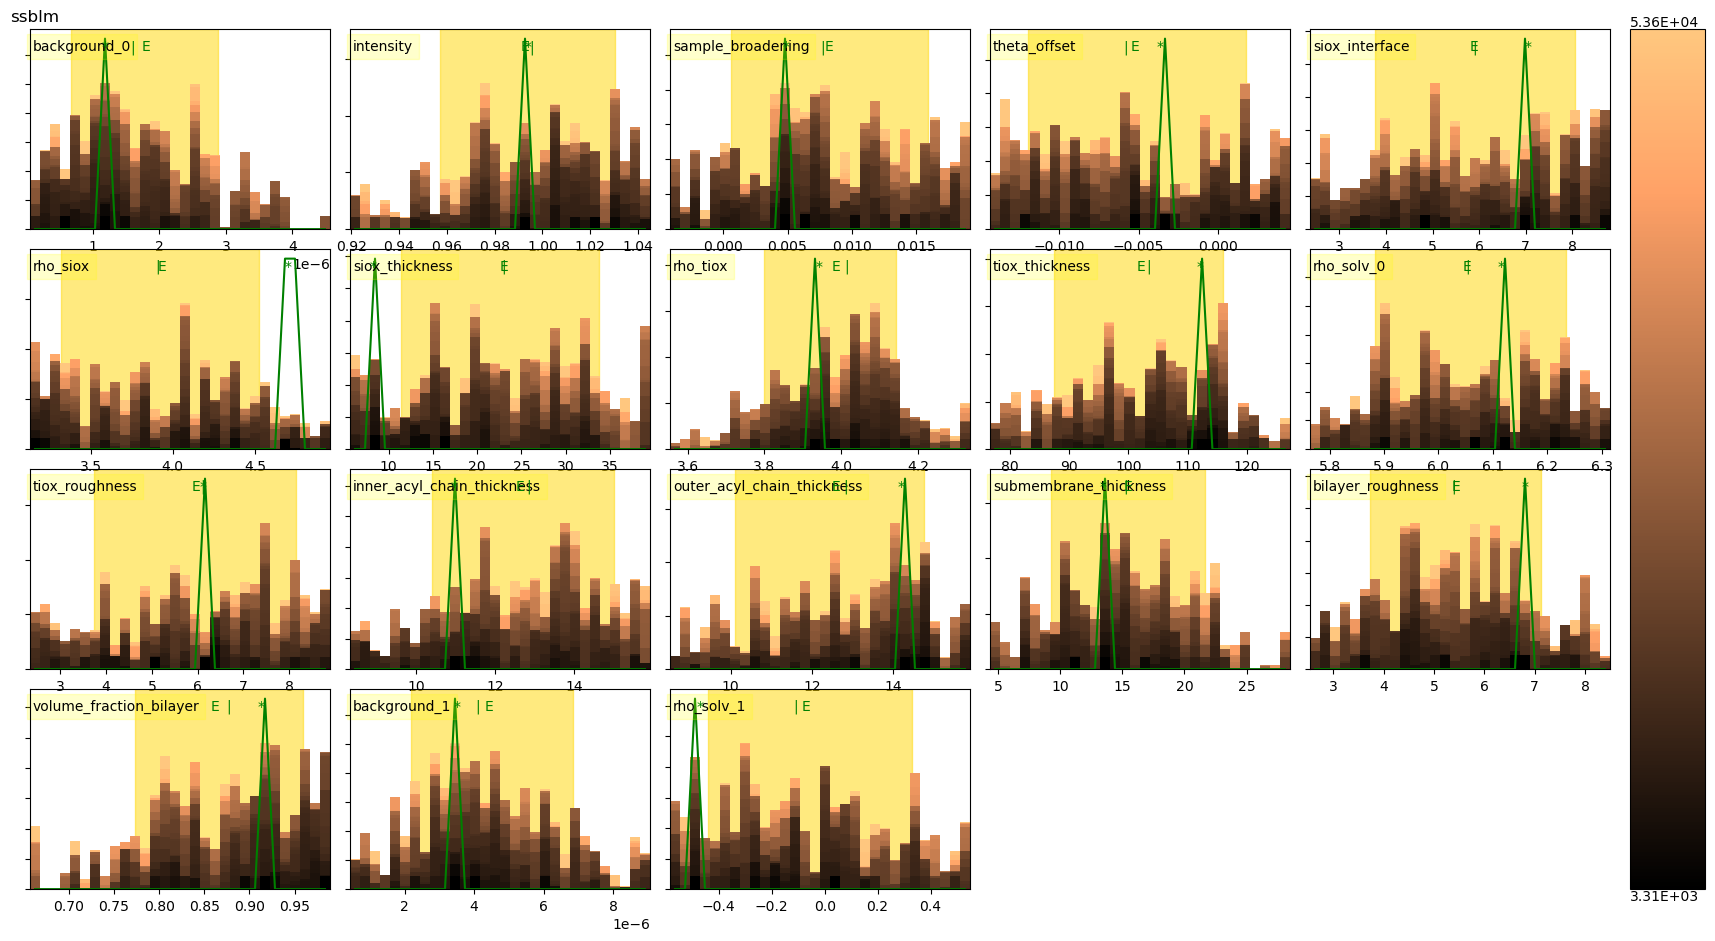

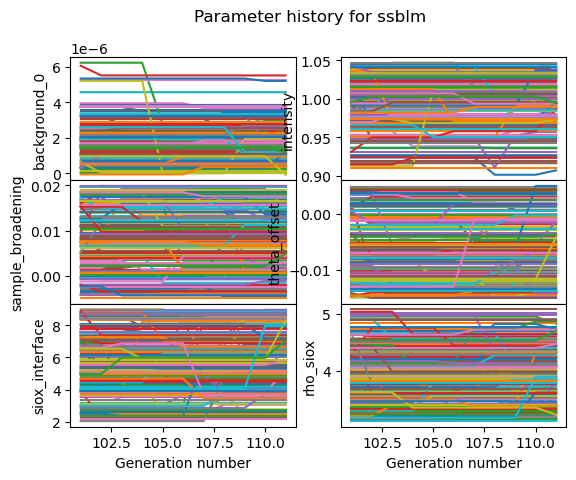

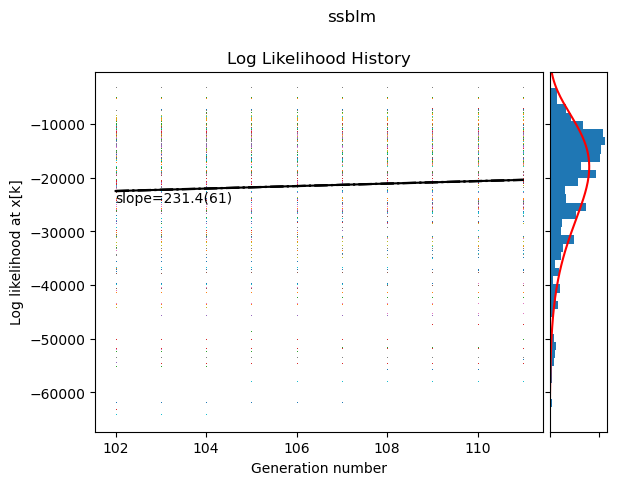

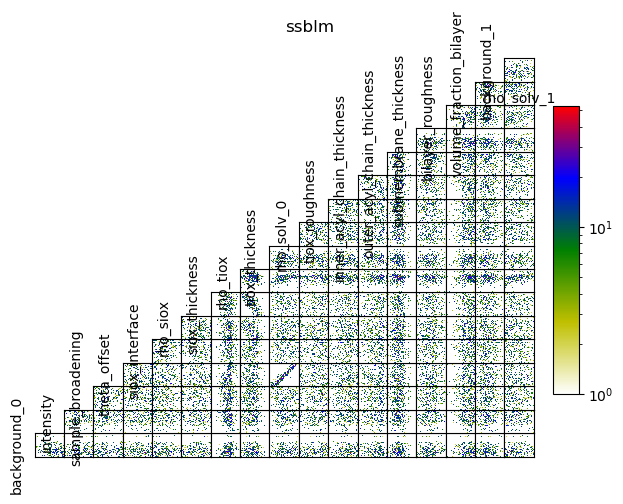

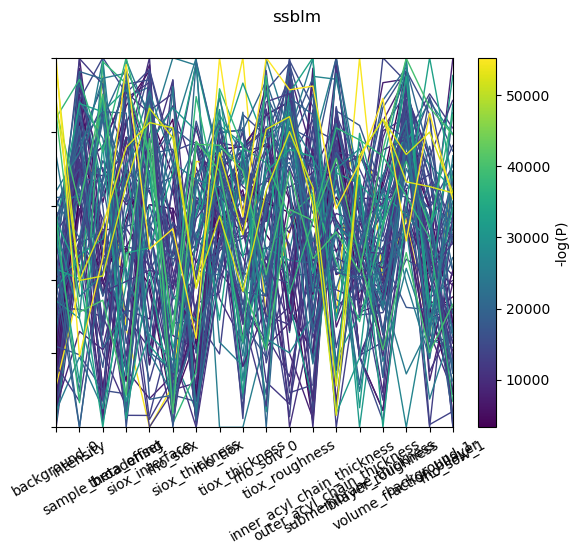

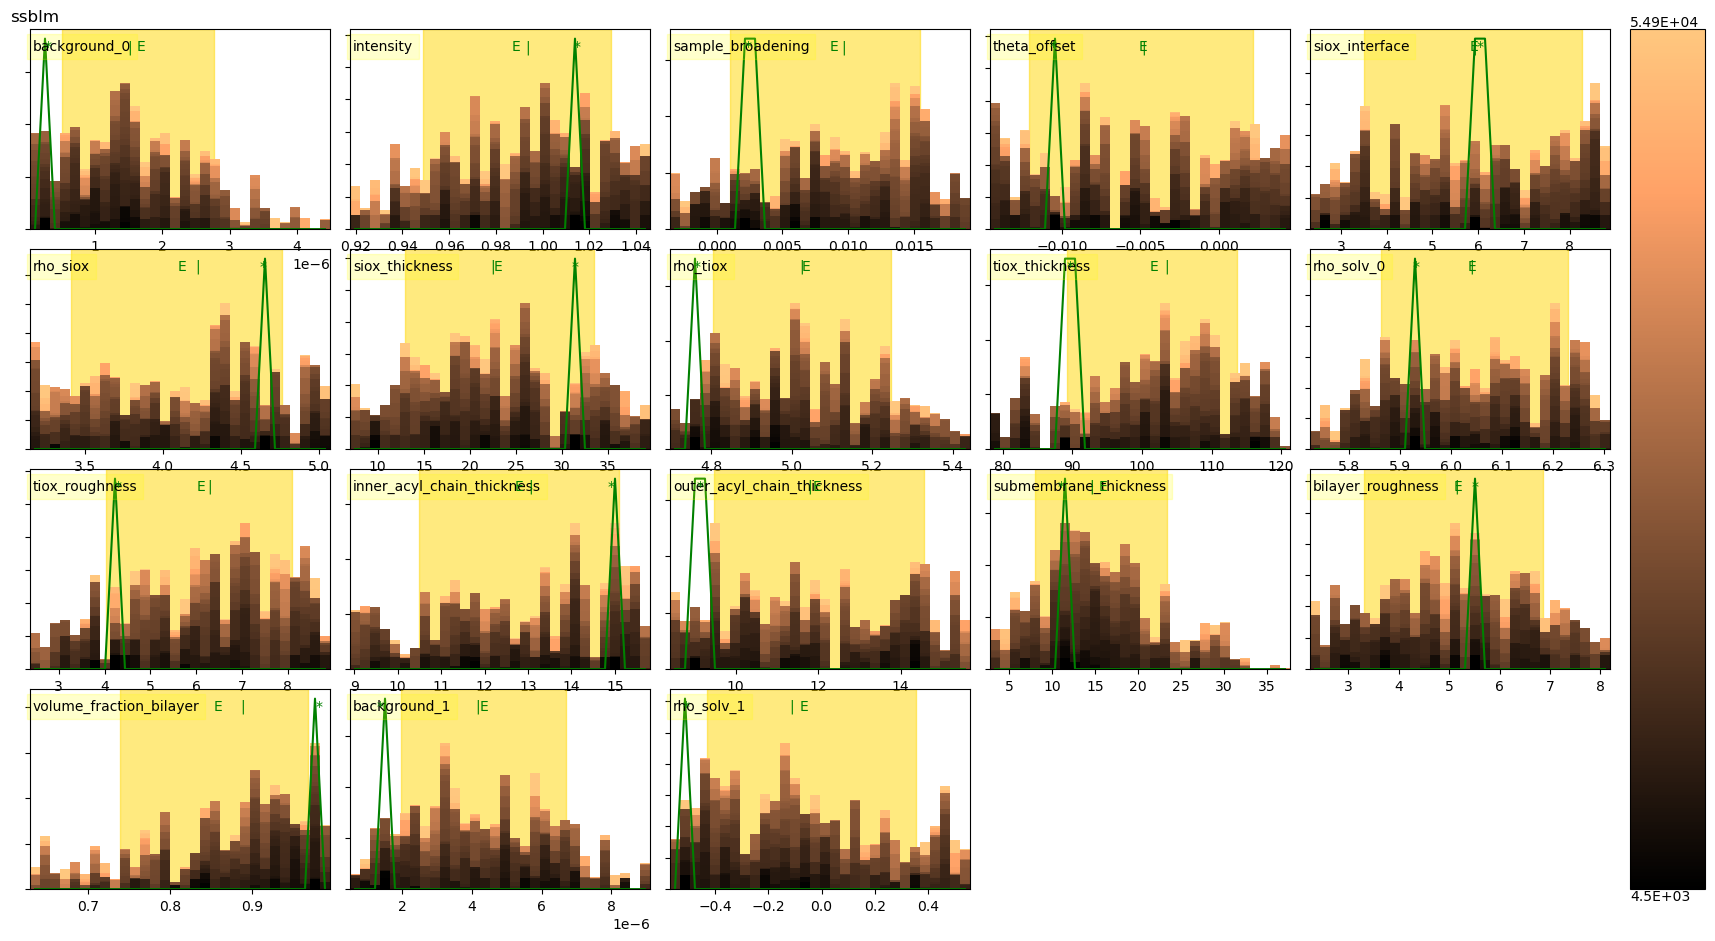

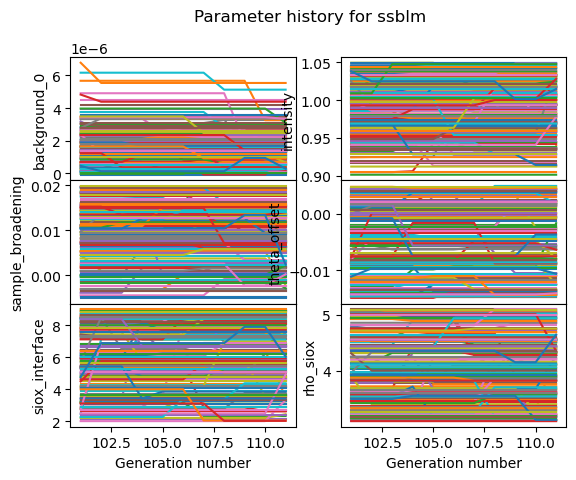

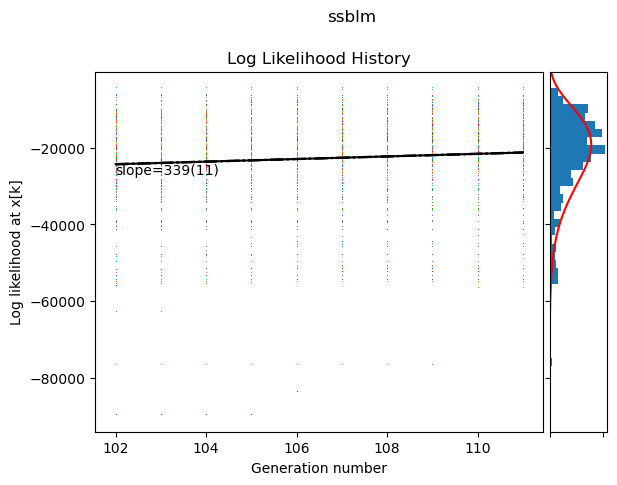

In [ ]:
entr.run_optimization()

In [ ]:
entr.plot_results()

In [ ]:
for M in entr.molstat.Interactor.problem.models:
    print(dir(M))
    print(M.fitness.reflectivity())

In [ ]:
entr.molstat.Interactor.problem._parameters